# Getting Started with PySpark

## Install Spark & Java

Spark requires Java to run because it is built on the JVM. We download and extract Apache Spark (version 3.5.0). The findspark library helps Python to locate Spark installation easily.


In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark kaggle

## Import required libraries

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, count, desc, split, explode
import matplotlib.pyplot as plt
import findspark

## Set Environment Variables

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

## Initialize Spark Session

SparkSession is the entry point to Spark functionality in Python (PySpark). We will create a Spark application called "Netflix-Spark-Activity".

In [ ]:
findspark.init()
spark = SparkSession.builder.appName("Netflix-Spark-Analysis").getOrCreate()
spark

## Load Dataset into Spark

We can use the colab upload feature if needed, or cancel and upload to files.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving netflix_titles.csv to netflix_titles.csv


In [ ]:
df = spark.read.csv("netflix_titles.csv", header=True, inferSchema=True)
df.printSchema()
df.show()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|            director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+

## Some Basic EDA

In [ ]:
print("Total rows:", df.count())

print("Columns:", df.columns)

Total rows: 8809
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


## Basic Cleaning of Data

In [ ]:
df = df.dropDuplicates()

df = df.na.drop(subset=['title'])

for c in df.columns:
    nulls = df.filter(col(c).isNull()).count()
    print(f"Nulls in {c}: {nulls}")


Nulls in show_id: 0
Nulls in type: 0
Nulls in title: 0
Nulls in director: 2635
Nulls in cast: 825
Nulls in country: 831
Nulls in date_added: 12
Nulls in release_year: 1
Nulls in rating: 5
Nulls in duration: 4
Nulls in listed_in: 1
Nulls in description: 1


In [ ]:
df.filter(~col("release_year").rlike("^\d{4}$")).select("release_year", "title").show(100)
df = df.filter(col("release_year").rlike("^\d{4}$"))
df.count()

+-----------------+--------------------+
|     release_year|               title|
+-----------------+--------------------+
|       Paul Sambo|        King of Boys|
| January 15, 2021|What Would Sophia...|
|   Peter Ferriero|            Backfire|
|       Nick Kroll|Get Him to the Greek|
|  August 13, 2020|        An Easy Girl|
|     Ted Ferguson|    Hurricane Bianca|
|   Francis Weddey| Beasts of No Nation|
|   Charles Rocket|  Dances with Wolves|
|    Nse Ikpe-Etim|King of Boys: The...|
| January 13, 2021| An Imperfect Murder|
| Kristen Johnston|Hurricane Bianca:...|
|          Dr. Dre|      Rhyme & Reason|
|    United States| The Next Karate Kid|
| Marquell Manning|             Dayveon|
| Álvaro Cervantes|Offering to the S...|
|     Imanol Arias|The Legacy of the...|
|      Jade Eshete|         It's Bruno!|
|December 15, 2020|       The Challenge|
|    June 12, 2021|To All the Boys: ...|
+-----------------+--------------------+



8787

## Filtering data

Using dot notation/method chaining to:
* Count total rows
* Count by Type (Movie vs TV Show)
* Top 10 Countries with Most Content
* Filter Shows Released After 2018

In [ ]:
print(f"Total rows: {df.count()}")
df.groupBy("type").count().show()
df.groupBy("country").count().orderBy("count", ascending=False).show(10)
df.filter(df["release_year"] > 2018).select("title", "release_year").show(10)

Total rows: 8787
+-------+-----+
|   type|count|
+-------+-----+
|TV Show| 2673|
|  Movie| 6114|
+-------+-----+

+--------------+-----+
|       country|count|
+--------------+-----+
| United States| 2805|
|         India|  972|
|          NULL|  830|
|United Kingdom|  419|
|         Japan|  245|
|   South Korea|  199|
|        Canada|  181|
|         Spain|  145|
|        France|  123|
|        Mexico|  110|
+--------------+-----+
only showing top 10 rows

+--------------------+------------+
|               title|release_year|
+--------------------+------------+
|               Aziza|        2019|
|Jungle Beat: The ...|        2021|
|      Alone/Together|        2019|
|     The Wolf's Call|        2019|
|         Paris Is Us|        2019|
|      The Underclass|        2020|
|           Al acecho|        2019|
|Dragon Quest Your...|        2019|
|             Monsoon|        2020|
|  Thomas and Friends|        2020|
+--------------------+------------+
only showing top 10 rows



Grouping by release year

In [ ]:
df_grouped = (
    df.groupBy("release_year")
    .count()
    .orderBy(desc("release_year"))
)

df_grouped.show(100)


+------------+-----+
|release_year|count|
+------------+-----+
|        2021|  589|
|        2020|  952|
|        2019| 1026|
|        2018| 1145|
|        2017| 1030|
|        2016|  901|
|        2015|  559|
|        2014|  352|
|        2013|  288|
|        2012|  237|
|        2011|  185|
|        2010|  193|
|        2009|  152|
|        2008|  136|
|        2007|   88|
|        2006|   95|
|        2005|   80|
|        2004|   64|
|        2003|   61|
|        2002|   51|
|        2001|   45|
|        2000|   37|
|        1999|   39|
|        1998|   36|
|        1997|   37|
|        1996|   24|
|        1995|   25|
|        1994|   21|
|        1993|   28|
|        1992|   23|
|        1991|   17|
|        1990|   21|
|        1989|   16|
|        1988|   18|
|        1987|    8|
|        1986|   13|
|        1985|   10|
|        1984|   12|
|        1983|   11|
|        1982|   17|
|        1981|   13|
|        1980|   11|
|        1979|   11|
|        1978|    7|
|        1977

## Filtering by a keyword in title

In [ ]:
# Titles containing "Love"
df.filter(col("title").contains("Love")).select("title", "release_year").show(10)

+--------------------+------------+
|               title|release_year|
+--------------------+------------+
|   When Love Happens|        2014|
|          Much Loved|        2015|
|     P.S. I Love You|        2007|
|           Love Shot|        2018|
|    Falling Inn Love|        2019|
|      Love Ni Bhavai|        2017|
|The Forest of Lov...|        2020|
|Love Like the Fal...|        2020|
|  The Forest of Love|        2019|
|     Brother in Love|        2019|
+--------------------+------------+
only showing top 10 rows



## Spark SQL

A SQL view called netflix to run SQL queries. This shows Spark’s flexibility in that it allows us to use SQL on big data directly.

In [ ]:
df.createOrReplaceTempView("netflix")

# Count Movies vs TV Shows
spark.sql("SELECT type, COUNT(*) AS total FROM netflix GROUP BY type").show()

# Top 5 Directors with Most Titles
spark.sql("""
SELECT director, COUNT(*) as total_titles
FROM netflix
WHERE director IS NOT NULL
GROUP BY director
ORDER BY total_titles DESC
LIMIT 5
""").show()

# Movies from South Africa
spark.sql("""
SELECT title, release_year
FROM netflix
WHERE type = 'Movie' AND country LIKE '%South Africa%'
ORDER BY release_year DESC
""").show(5)

+-------+-----+
|   type|total|
+-------+-----+
|TV Show| 2673|
|  Movie| 6114|
+-------+-----+

+--------------------+------------+
|            director|total_titles|
+--------------------+------------+
|       Rajiv Chilaka|          19|
|Raúl Campos, Jan ...|          18|
|        Marcus Raboy|          16|
|         Suhas Kadav|          16|
|           Jay Karas|          14|
+--------------------+------------+

+--------------------+------------+
|               title|release_year|
+--------------------+------------+
|Loyiso Gola: Unle...|        2021|
|Trippin' with the...|        2021|
|                Slay|        2021|
|      I Am All Girls|        2021|
|    Seriously Single|        2020|
+--------------------+------------+
only showing top 5 rows



## Visualization

We need to convert Spark DataFrame to Pandas for visualization.

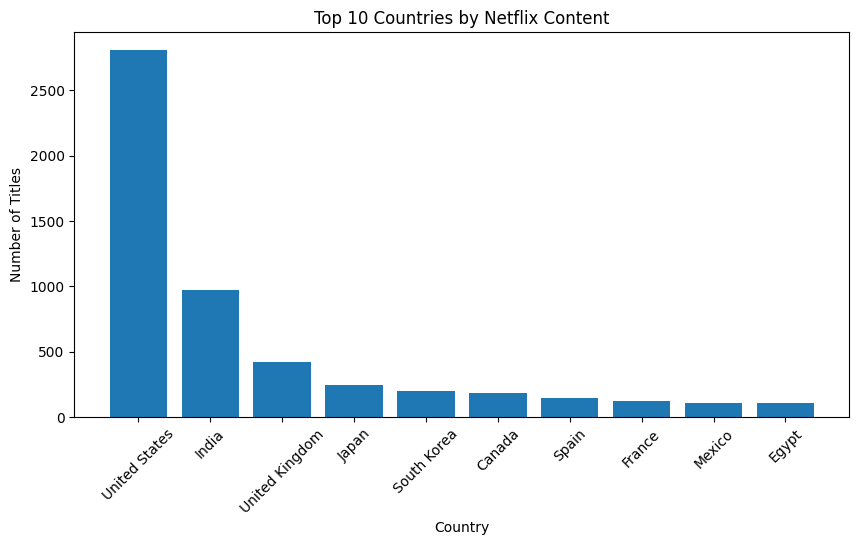

In [ ]:
# Top 10 countries
country_data = df.filter(df["country"].isNotNull()) \
    .groupBy("country").count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()

plt.figure(figsize=(10,5))
plt.bar(country_data["country"], country_data["count"])
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Netflix Content")
plt.xlabel("Country")
plt.ylabel("Number of Titles")
plt.show()

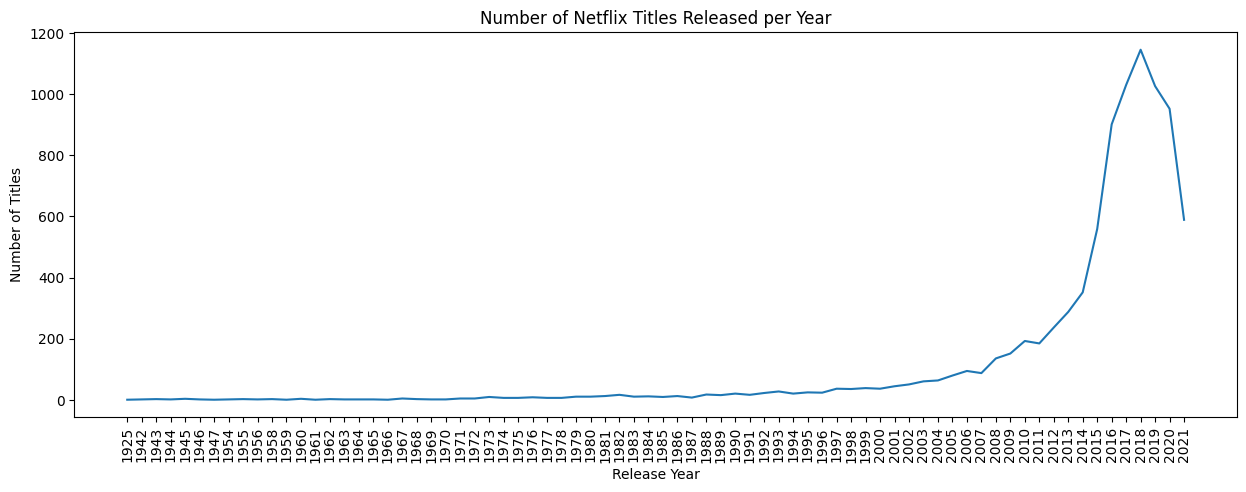

In [ ]:
# Total titles per year
titles_per_year = (
    df.groupBy("release_year")
    .count()
    .orderBy("release_year")
    .toPandas()
)

plt.figure(figsize=(15,5))
plt.plot(titles_per_year["release_year"], titles_per_year["count"])
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.xticks(rotation=90)
plt.title("Number of Netflix Titles Released per Year")
plt.show()

## Discussion Questions

Why is Spark better than Pandas for large datasets? Hint: Distributed processing vs single machine memory limits

How does Spark SQL make querying easier?

Where would a Spark cluster provide cost advantages for a company like Netflix?